In [1]:
import tensorflow as tf
from training_utils import download_file, get_batches, read_and_decode_single_example, load_validation_data, \
    download_data, evaluate_model, get_training_data, load_weights, flatten

C:\Users\eric\Anaconda2\envs\exts-aml2\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [ ]:
config = tf.ConfigProto()
how = "normal"
which = 8
batch_size = 32
dataset = 8
model_name = "model_s1.0.0.29l.8.2"
## Evaluate on test data multi-class
with tf.Session() as sess:
    # get the graph
    graph = tf.get_default_graph()
    
    # restore the graph
    saver = tf.train.import_meta_graph('./model/' + model_name + '.ckpt.meta', clear_devices=True)
    
    # restore the weights
    saver.restore(sess, './model/' + model_name + '.ckpt')
    
    # create the placeholders to feed
    X = tf.placeholder(shape=[None, 299, 299, 1], dtype=tf.float32)
    y = tf.placeholder(shape=[None], dtype=tf.int32)
    training = graph.get_tensor_by_name("is_training_2:0")
    
    # create the update ops
    extra_update_ops = tf.get_collection('extra_update_ops')
    probabilities = graph.get_tensor_by_name("probabilities:0")
    predictions = tf.argmax(probabilities, axis=1, output_type=tf.int64)
    recall, rec_op = tf.metrics.recall(labels=y, predictions=predictions, updates_collections=tf.GraphKeys.UPDATE_OPS, name="recall")
    
    # get the accuracy
    accuracy, acc_op = tf.metrics.accuracy(
        labels=y,
        predictions=predictions,
        updates_collections=tf.GraphKeys.UPDATE_OPS,
        name="accuracy",
    )
    sess.run(tf.local_variables_initializer())
    
    print("Restoring model", model_name)
    
    # load the test data
    X_te, y_te = load_validation_data(how=how, data="test", which=dataset)
    print("Evaluating on test data")
    
    test_accuracy = []
    test_recall = []
    test_predictions = []
    ground_truth = []
    test_recall_value = 0
    i = 1
    for X_batch, y_batch in get_batches(X_te, y_te, batch_size, distort=False):
        print("Batch", i)
        i += 1
        _, yhat, test_acc_value = sess.run([extra_update_ops, predictions, accuracy], feed_dict=
        {
            X: X_batch,
            y: y_batch,
            training: False,
        })

        test_accuracy.append(test_acc_value)
        test_recall.append(test_recall_value)
        test_predictions.append(yhat)
        ground_truth.append(y_batch)

    # print the results
    print()
    print("Mean Test Accuracy:", np.mean(test_accuracy))
    print("Mean Test Recall:", np.mean(test_recall))
    
    # unlist the predictions and truth
    test_predictions = flatten(test_predictions)
    ground_truth = flatten(ground_truth)
    
    # save the predictions and truth for review
    np.save(os.path.join("data", "predictions_" + model_name + ".npy"), test_predictions)
    np.save(os.path.join("data", "truth_" + model_name + ".npy"), ground_truth)

INFO:tensorflow:Restoring parameters from ./model/model_s1.0.0.29l.8.2.ckpt
Restoring model model_s1.0.0.29l.8.2
Evaluating on test data
Batch 1


In [22]:
import numpy as np
truth = np.random.binomial(1, 0.8, 1000)
yhat = np.random.binomial(1, 0.2, 1000)

In [23]:
tp = np.sum(truth & yhat)
fn = np.sum(truth & ~yhat)

In [24]:
recall = tp / (tp + fn)
recall

0.18546365914786966

In [25]:
# try the recall in batches
batch_size = 50
recall_list = []

for i in range(20):
    start = i * batch_size
    batch_truth = truth[start:start+batch_size]
    batch_yhat = yhat[start:start+batch_size]
    
    batch_tp = np.sum(batch_truth & batch_yhat)
    batch_fn = np.sum(batch_truth & ~batch_yhat)
    
    batch_recall = batch_tp / (batch_tp + batch_fn)
    
    recall_list.append(batch_recall)
    
np.mean(recall_list)

0.18594050881251975

## Create plots for report

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import os
%matplotlib inline

def plot_metrics(model_name, classification, dataset, model_dir=None, vline=None, vlabel=None):
    if model_dir == None:
        model_dir = model_name
        
    train_acc_values = np.load(os.path.join("data", "results", model_dir, model_name + "train_acc.npy"))
    valid_acc_values = np.load(os.path.join("data", "results", model_dir, model_name + "cv_acc.npy"))

    train_cost_values = np.load(os.path.join("data", "results", model_dir, model_name + "train_loss.npy"))
    valid_cost_values = np.load(os.path.join("data", "results", model_dir, model_name + "cv_loss.npy"))

    train_recall_values = np.load(os.path.join("data", "results", model_dir, model_name + "train_recall.npy"))
    valid_recall_values = np.load(os.path.join("data", "results", model_dir, model_name + "cv_recall.npy"))

    train_lr_values = np.load(os.path.join("data", "results", model_dir, model_name + "train_lr.npy"))
    
    # initialize the plots
    f, ax = plt.subplots(1, 2, figsize=(10, 4))

    ax[0].plot(valid_acc_values, color="red", label="Validation")
    ax[0].plot(train_acc_values, color="blue", label="Training")
    ax[0].axhline(y=0.83, color="salmon", label="Baseline Accuracy")
    ax[0].set_title('Validation accuracy: {:.4f} (mean last 4)'.format(np.mean(valid_acc_values[-4:])))
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Accuracy')
    ax[0].set_ylim([0.3,1.0])

    # draw vertical line if one is passed in
    if vline is not None:
        ax[0].axvline(x=vline, color="black", label=vlabel)
        
    ax[0].legend()
    
    ax[1].plot(train_recall_values, color="red", label="Validation")
    ax[1].plot(valid_recall_values, color="blue", label="Training")
    ax[1].set_title('Validation Recall: {:.3f} (mean last 4)'.format(np.mean(valid_recall_values[-4:])))
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Recall')
    ax[1].legend()

    f.suptitle("Results for " + model_name + " " + classification + " (Dataset " + str(dataset) + ")")
    plt.show()

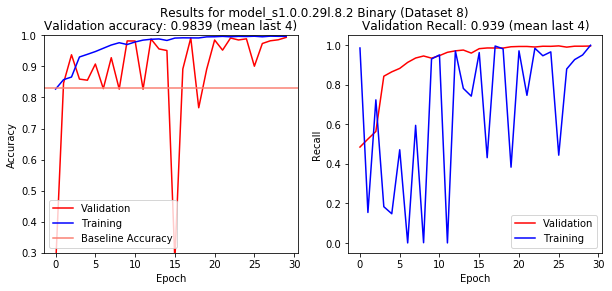

In [6]:
plot_metrics("model_s1.0.0.29l.8.2", classification="Binary", dataset=8)

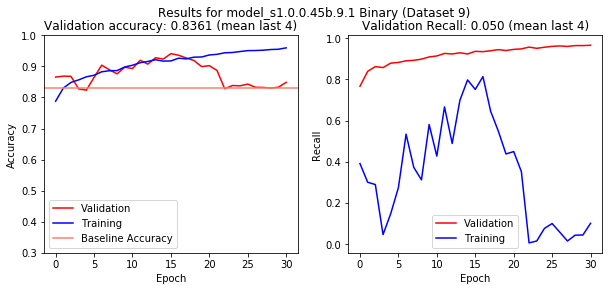

In [7]:
plot_metrics("model_s1.0.0.45b.9.1", classification="Binary", dataset=9)

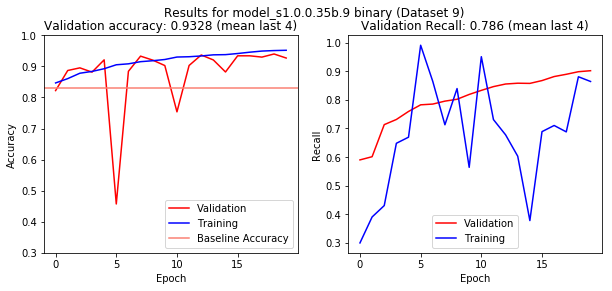

In [8]:
plot_metrics("model_s1.0.0.35b.9", classification="binary", dataset=9)